# Sequence Learning - Direct - English - Testing Session - Phoneme Plots
20230921: Progression plot of single phonemes.  
Written after finding out the failure of model learning representation of phonemes but only remenbering occurrance 
orders. This is bad, since what we wanted to see was that the model could separate the different phonemes (at least phones).   
However, it remains a doubt whether the model has learned the conditional & nonconditional distribution of 
phonemes, despite not learning them separately. That is to say, we want to know whether the model has learned to put phonemes
that love to stay in very distinct phonological contexts into distinct places OR whether the model can only distinguish this 
when they are in the context. That is, ex. whether /ng/ will be projected to ONSET community if being fed alone or it will 
be projected to CODA community like when fed with words. 

20230927: this time we have 8 dimensional hidden representation. Try to plot and observe what is in there. 

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import plotly.express as px
import random
from sklearn.manifold import TSNE  # Optional: Use t-SNE for dimensionality reduction
import seaborn as sns
from collections import Counter

In [2]:
from padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from my_utils import *
from loss import *
from model import SimplerPhxLearnerle as TheLearner
from dataset import SeqDatasetAnno, MelSpecTransform, Normalizer, DeNormalizer
from dataset import MelSpecTransformNoDB as TheTransform
from my_dataset import DS_Tools
from reshandler import AnnoEncoderResHandler
from misc_progress_bar import draw_progress_bar

## Preps

### Dirs

In [3]:
model_save_dir = model_eng_save_dir

log_path = phone_seg_anno_log_path
rec_path = phone_seg_anno_path

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Model

### Model-related defs

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

# model = SimplerPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
# model = LHYPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [6]:
load_ts = "0123102713"
stop_epoch = "15"

In [7]:
model_raw_name = "PT_{}_{}_full".format(load_ts, stop_epoch)
model_name = model_raw_name + ".pt"
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

TwoLinPhxLearner(
  (encoder): LRLEncoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=64, out_features=32, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (rnn): LSTM(32, 16, num_layers=2, batch_first=True)
    (lin_2): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): LRALDecoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=64, out_features=32, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (rnn): LSTM(32, 8, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_3): Linear(in_features=8, out_features=64, bias=True)
  )
)

### Dataset

- Note that due to the separate setting of word and phone datasets, we cannot really make it to select those that have not been trained on 
for this test. This is a point to further fix. Make reference to out first work. 

In [8]:
# mytrans = MelSpecTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS, normalizer=Normalizer.norm_mvn, denormalizer=DeNormalizer.norm_mvn)
ds = SeqDatasetAnno(rec_path, os.path.join(log_path, "log.csv"), transform=mytrans)

# valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(load_ts)))

# valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

# this is to reduce the size of the dataset when the training power is not sufficient
small_len = int(0.05 * len(ds))
other_len = len(ds) - small_len

# # Randomly split the dataset into train and validation sets
valid_ds, other_ds = random_split(ds, [small_len, other_len])

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=SeqDatasetAnno.collate_fn)
valid_num = len(valid_loader.dataset)

In [9]:
len(valid_loader)

41640

## Inference

In [10]:
def infer(): 
    model.eval()
    reshandler = AnnoEncoderResHandler(whole_res_dir=phone_plot_res_path, file_prefix=model_raw_name)
    all_res = np.empty((0, 8))
    all_token = []
    all_name = []

    log_token = []  # for making csv to map sound to filename
    log_name = []
    log_fc = []

    total = len(valid_loader)

    for idx, (x, x_lens, token, name) in enumerate(valid_loader): 
        token = token[0]
        name = name[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        hid_r = model.encode(x, x_lens, x_mask)

        hid_r = hid_r.cpu().detach().numpy().squeeze()

        length = hid_r.shape[0]

        all_res = np.concatenate((all_res, hid_r), axis=0)
        all_token += [token] * length
        all_name += [name] * length
        log_token += [token]
        log_name += [name]
        log_fc += [length]

        if idx % 10 == 0: 
            draw_progress_bar(idx, total)
    

    reshandler.res = all_res
    reshandler.tok = all_token
    reshandler.name = all_name
    reshandler.save()

    # save guideline
    df = pd.DataFrame({'Name': log_name, 'Token': log_token, 'FrameCount':log_fc})
    df.to_csv(os.path.join(phone_plot_res_path, model_raw_name + '_guide.csv'), index=False) 

In [11]:
if __name__ == "__main__": 
    infer()

[==================================================] 99%	

## Plotter

In [12]:
def manyOuts2progFrame(manyOuts, groups): 
    df = pd.DataFrame(manyOuts)
    df["name"] = groups

    df = df.sort_values(by=["name"])
    # Group the DataFrame by the grouping column and assign timesteps within each group
    df['timestep'] = df.groupby("name").cumcount() + 1
    return df

# Selective Plot

### Load Res

In [13]:
reshandler = AnnoEncoderResHandler(whole_res_dir=phone_plot_res_path, file_prefix=model_raw_name)
reshandler.read()

In [14]:
def select(data, guide, selector):
    # Ensure that the lengths of annotations and data_array match
    if len(guide) != data.shape[0]:
        raise ValueError("The length of guide must match the number of items in the data.")

    # Create a boolean mask for selected annotations
    mask = np.isin(guide, selector)

    # Use the mask to select the corresponding items from the data array
    selected_items = data[mask]

    return selected_items

### Multiplot by Phoneme

In [18]:
# get usable cluster groups
cluster_groups = ["aa", "uw"]

hidr_cs = select(data=reshandler.res, 
                 guide=reshandler.tok, 
                 selector=cluster_groups)
tags_cs = select(data=np.array(reshandler.tok), 
                 guide=reshandler.tok, 
                 selector=cluster_groups)
color_translate = {item: idx for idx, item in enumerate(cluster_groups)}

# Use Counter to count the occurrences of each item
item_counts = Counter(tags_cs)

# Print the item counts
for item, count in item_counts.items():
    print(f"{item}: {count}")

aa: 6763
uw: 5172


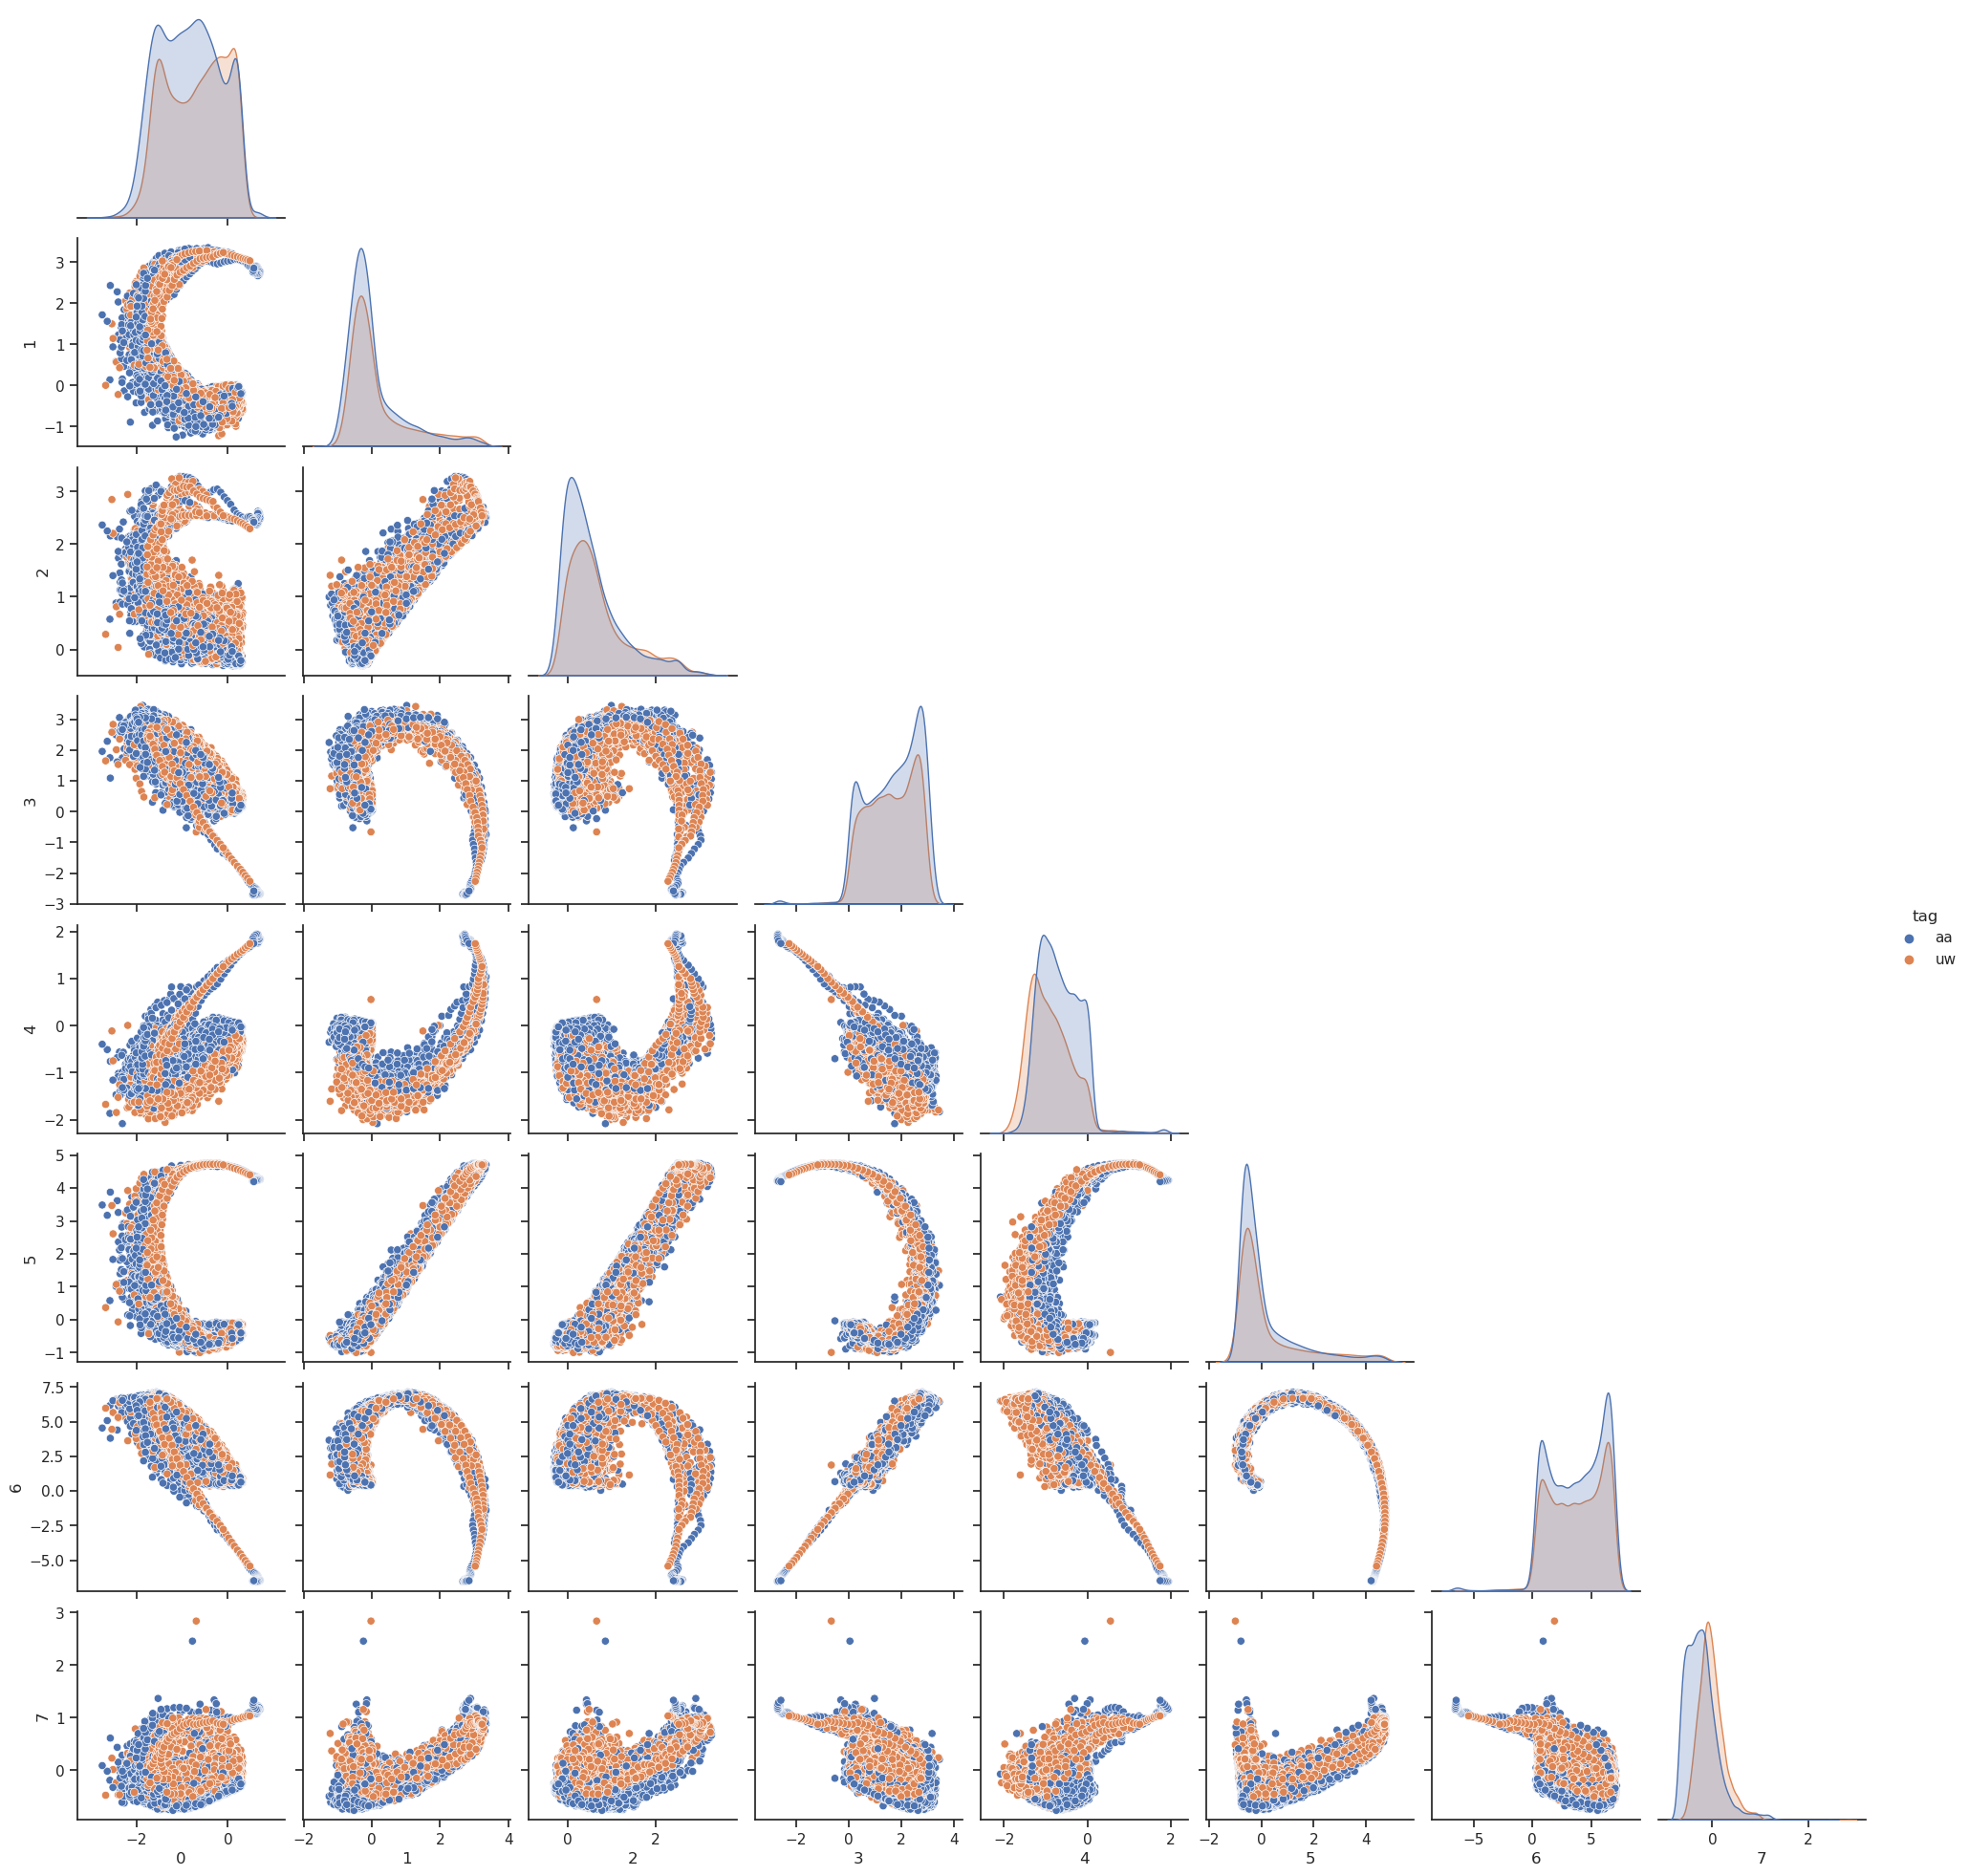

In [19]:
X = hidr_cs
y = tags_cs

colors = [color_translate[item] for item in y]
df = pd.DataFrame(X)
df["tag"] = y

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df,hue='tag', corner=True, diag_kind="kde")
# g.map_lower(sns.kdeplot, levels=4, color=".2")

### Plot by rec

In [17]:
guide_df = pd.read_csv(os.path.join(phone_plot_res_path, "{}_guide.csv".format(model_raw_name)))
total_len = len(guide_df["Name"].tolist())

all_name = guide_df["Name"]
all_token = guide_df["Token"]

In [18]:
randidx = random.randint(0, total_len)
save_name = all_name[randidx]
token = all_token[randidx]
print(save_name, token)

s1903a_00003392 t


In [19]:
hidr_cs = select(data=reshandler.res, 
                 guide=reshandler.name, 
                 selector=[save_name])

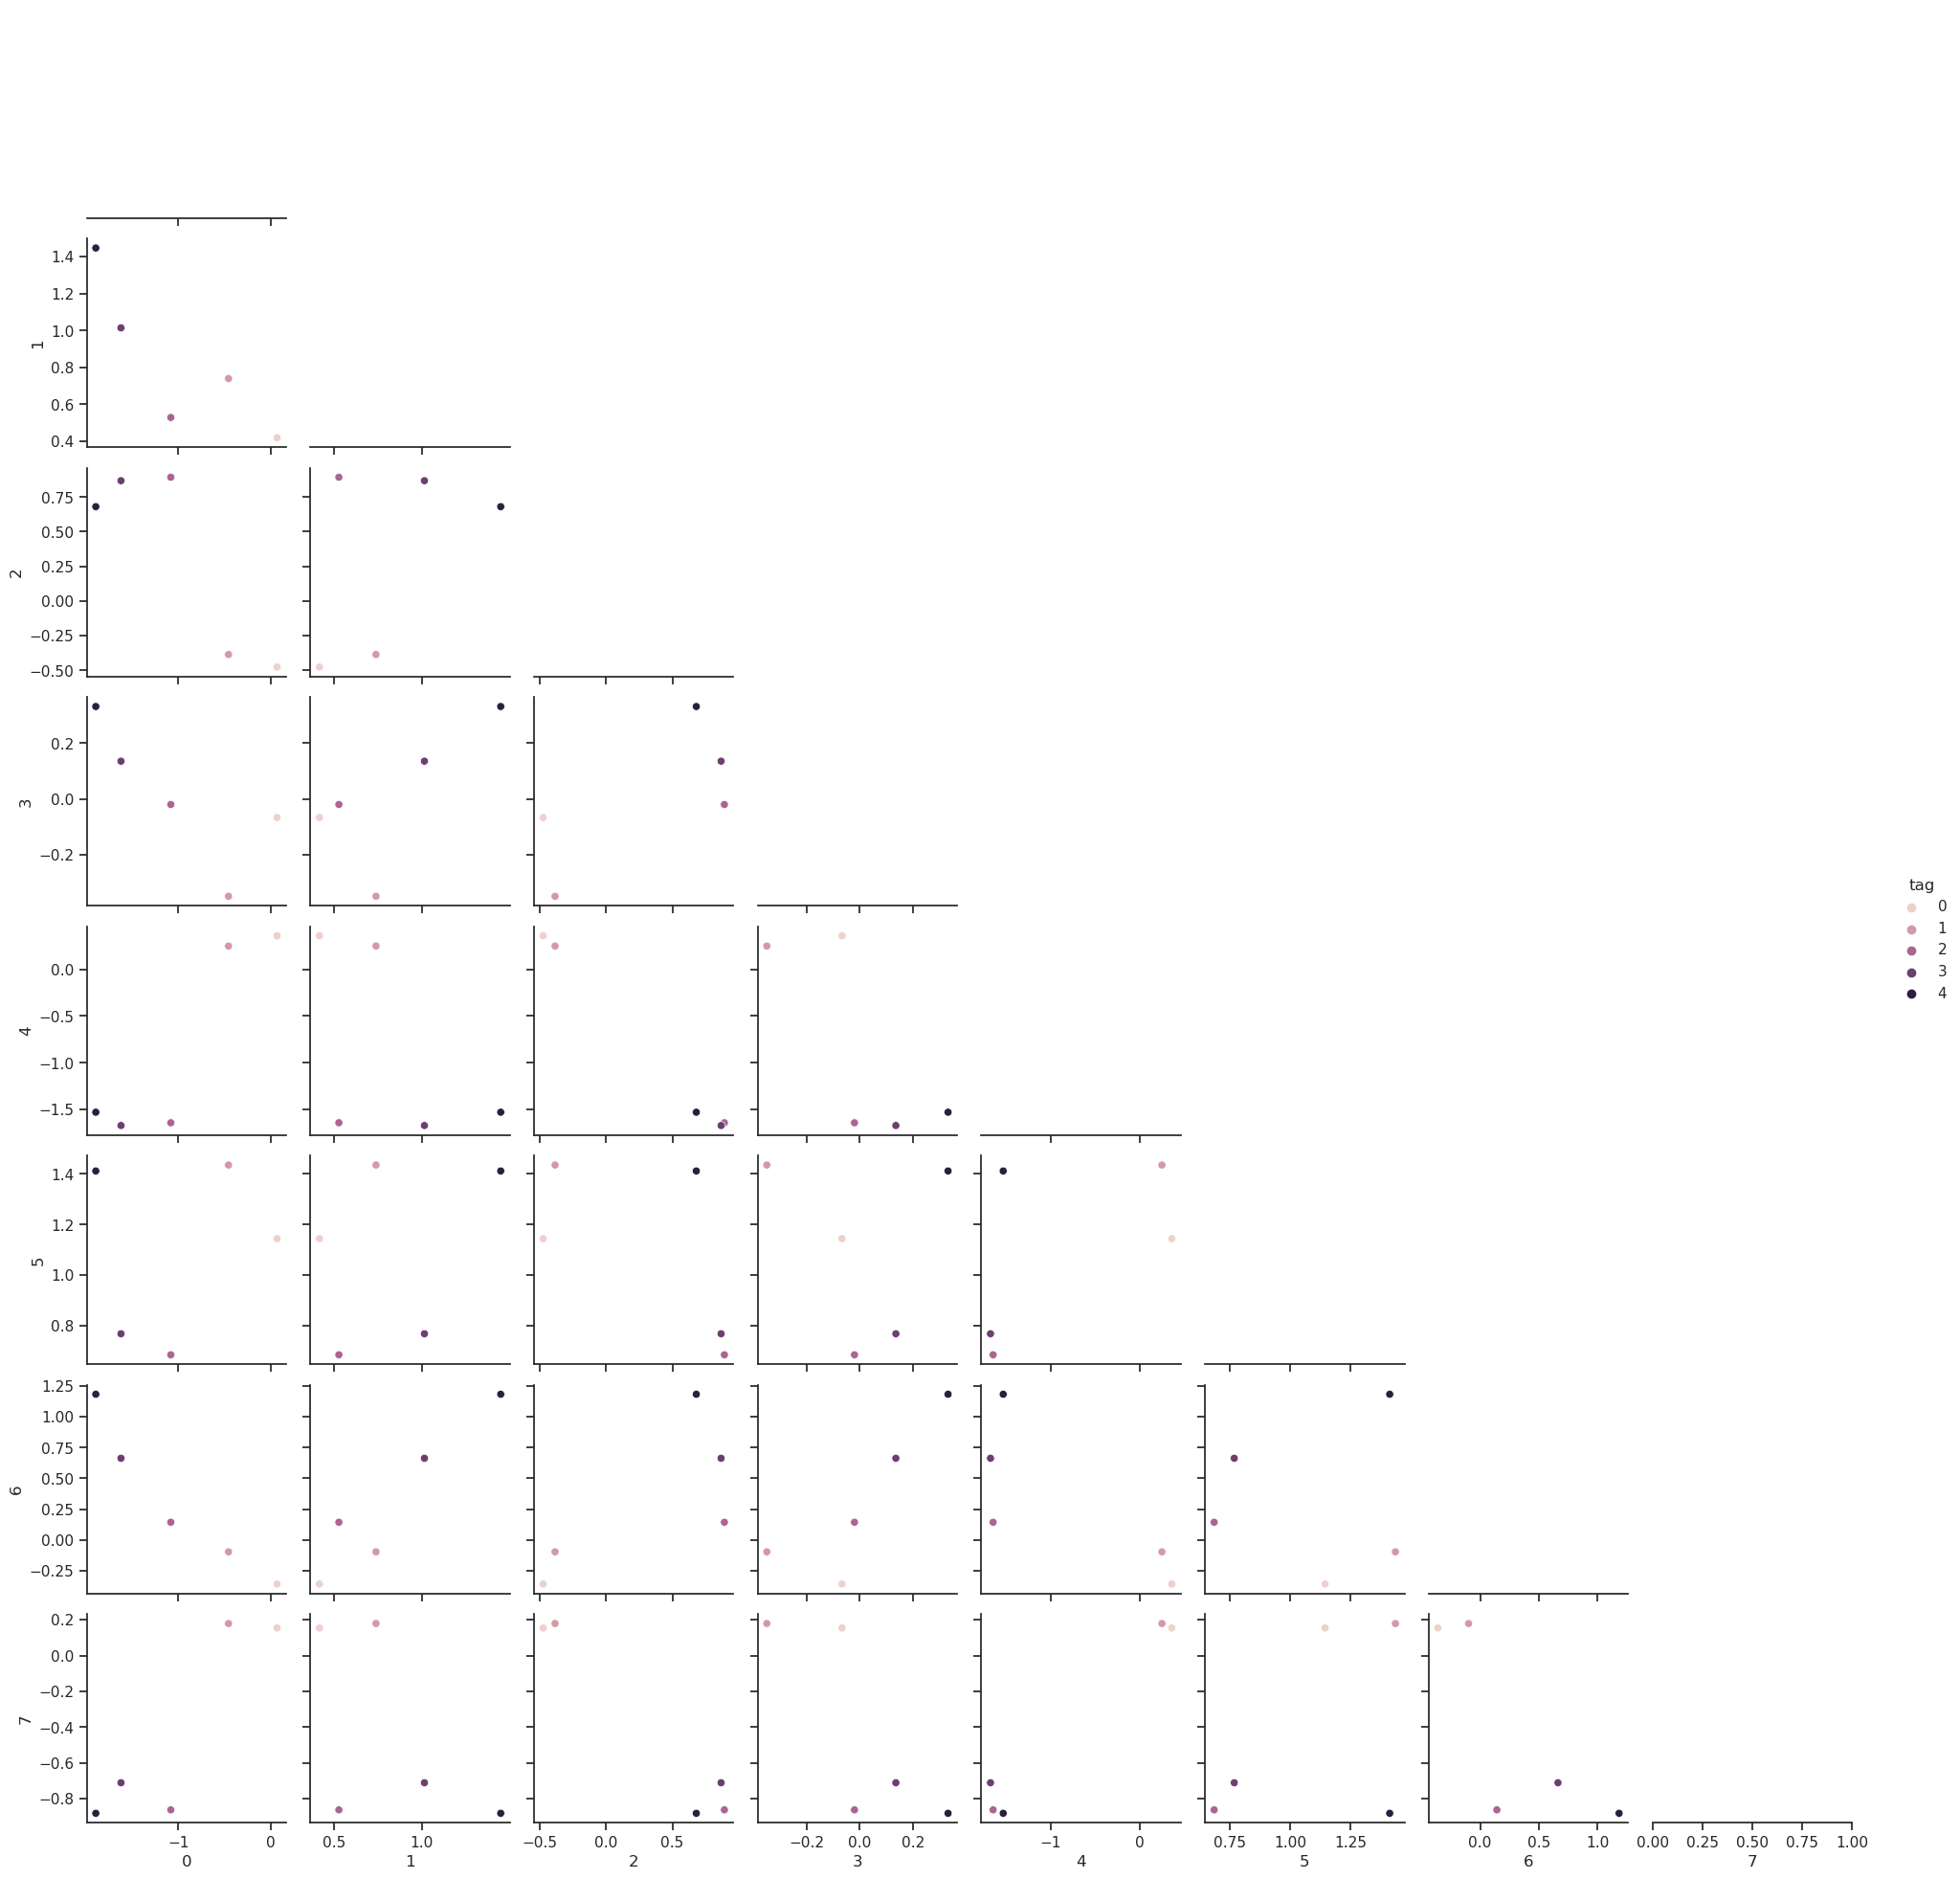

In [20]:
X = hidr_cs
y = list(range(hidr_cs.shape[0]))

df = pd.DataFrame(X)
df["tag"] = y

sns.set(style="ticks", color_codes=True)
sns.pairplot(df,hue='tag', corner=True)

### Plot by phoneme and rec

In [21]:
guide_df = pd.read_csv(os.path.join(phone_plot_res_path, "{}_guide.csv".format(model_raw_name)))
filtered_guide_df = guide_df[guide_df['FrameCount'] <= 10]

total_len = len(filtered_guide_df["Name"].tolist())

all_name = filtered_guide_df["Name"].to_numpy()
all_token = filtered_guide_df["Token"]

In [22]:
target_token = "ng"

names_by_token = select(data=all_name, 
                        guide=all_token, 
                        selector=[target_token])
names_by_token.shape

(428,)

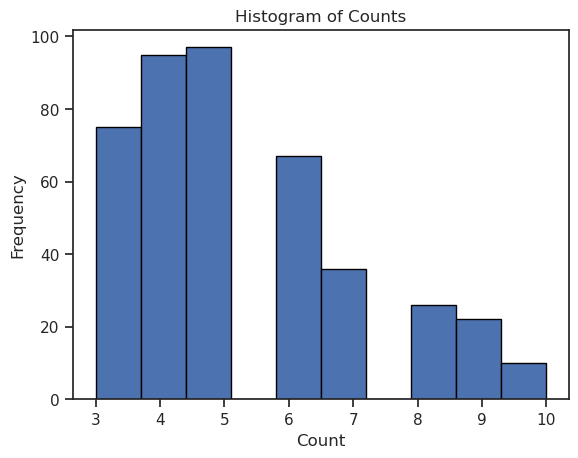

In [23]:
data = filtered_guide_df[filtered_guide_df["Token"] == target_token]["FrameCount"].to_numpy().tolist()

# Create a histogram of counts
plt.hist(data,  edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Counts')
plt.show()

In [24]:
selnum = 500

In [25]:
subset_size = selnum if selnum <= names_by_token.shape[0] else names_by_token.shape[0]
random_subset_names_by_token = np.random.choice(names_by_token, size=subset_size, replace=False)

In [26]:
hidr_cs = select(data=reshandler.res, 
                 guide=reshandler.name, 
                 selector=random_subset_names_by_token)
tags_cs = select(data=np.array(reshandler.name), 
                 guide=reshandler.name, 
                 selector=random_subset_names_by_token)

res_df = manyOuts2progFrame(hidr_cs, tags_cs)
res_df["timestep"].to_numpy().max()

10

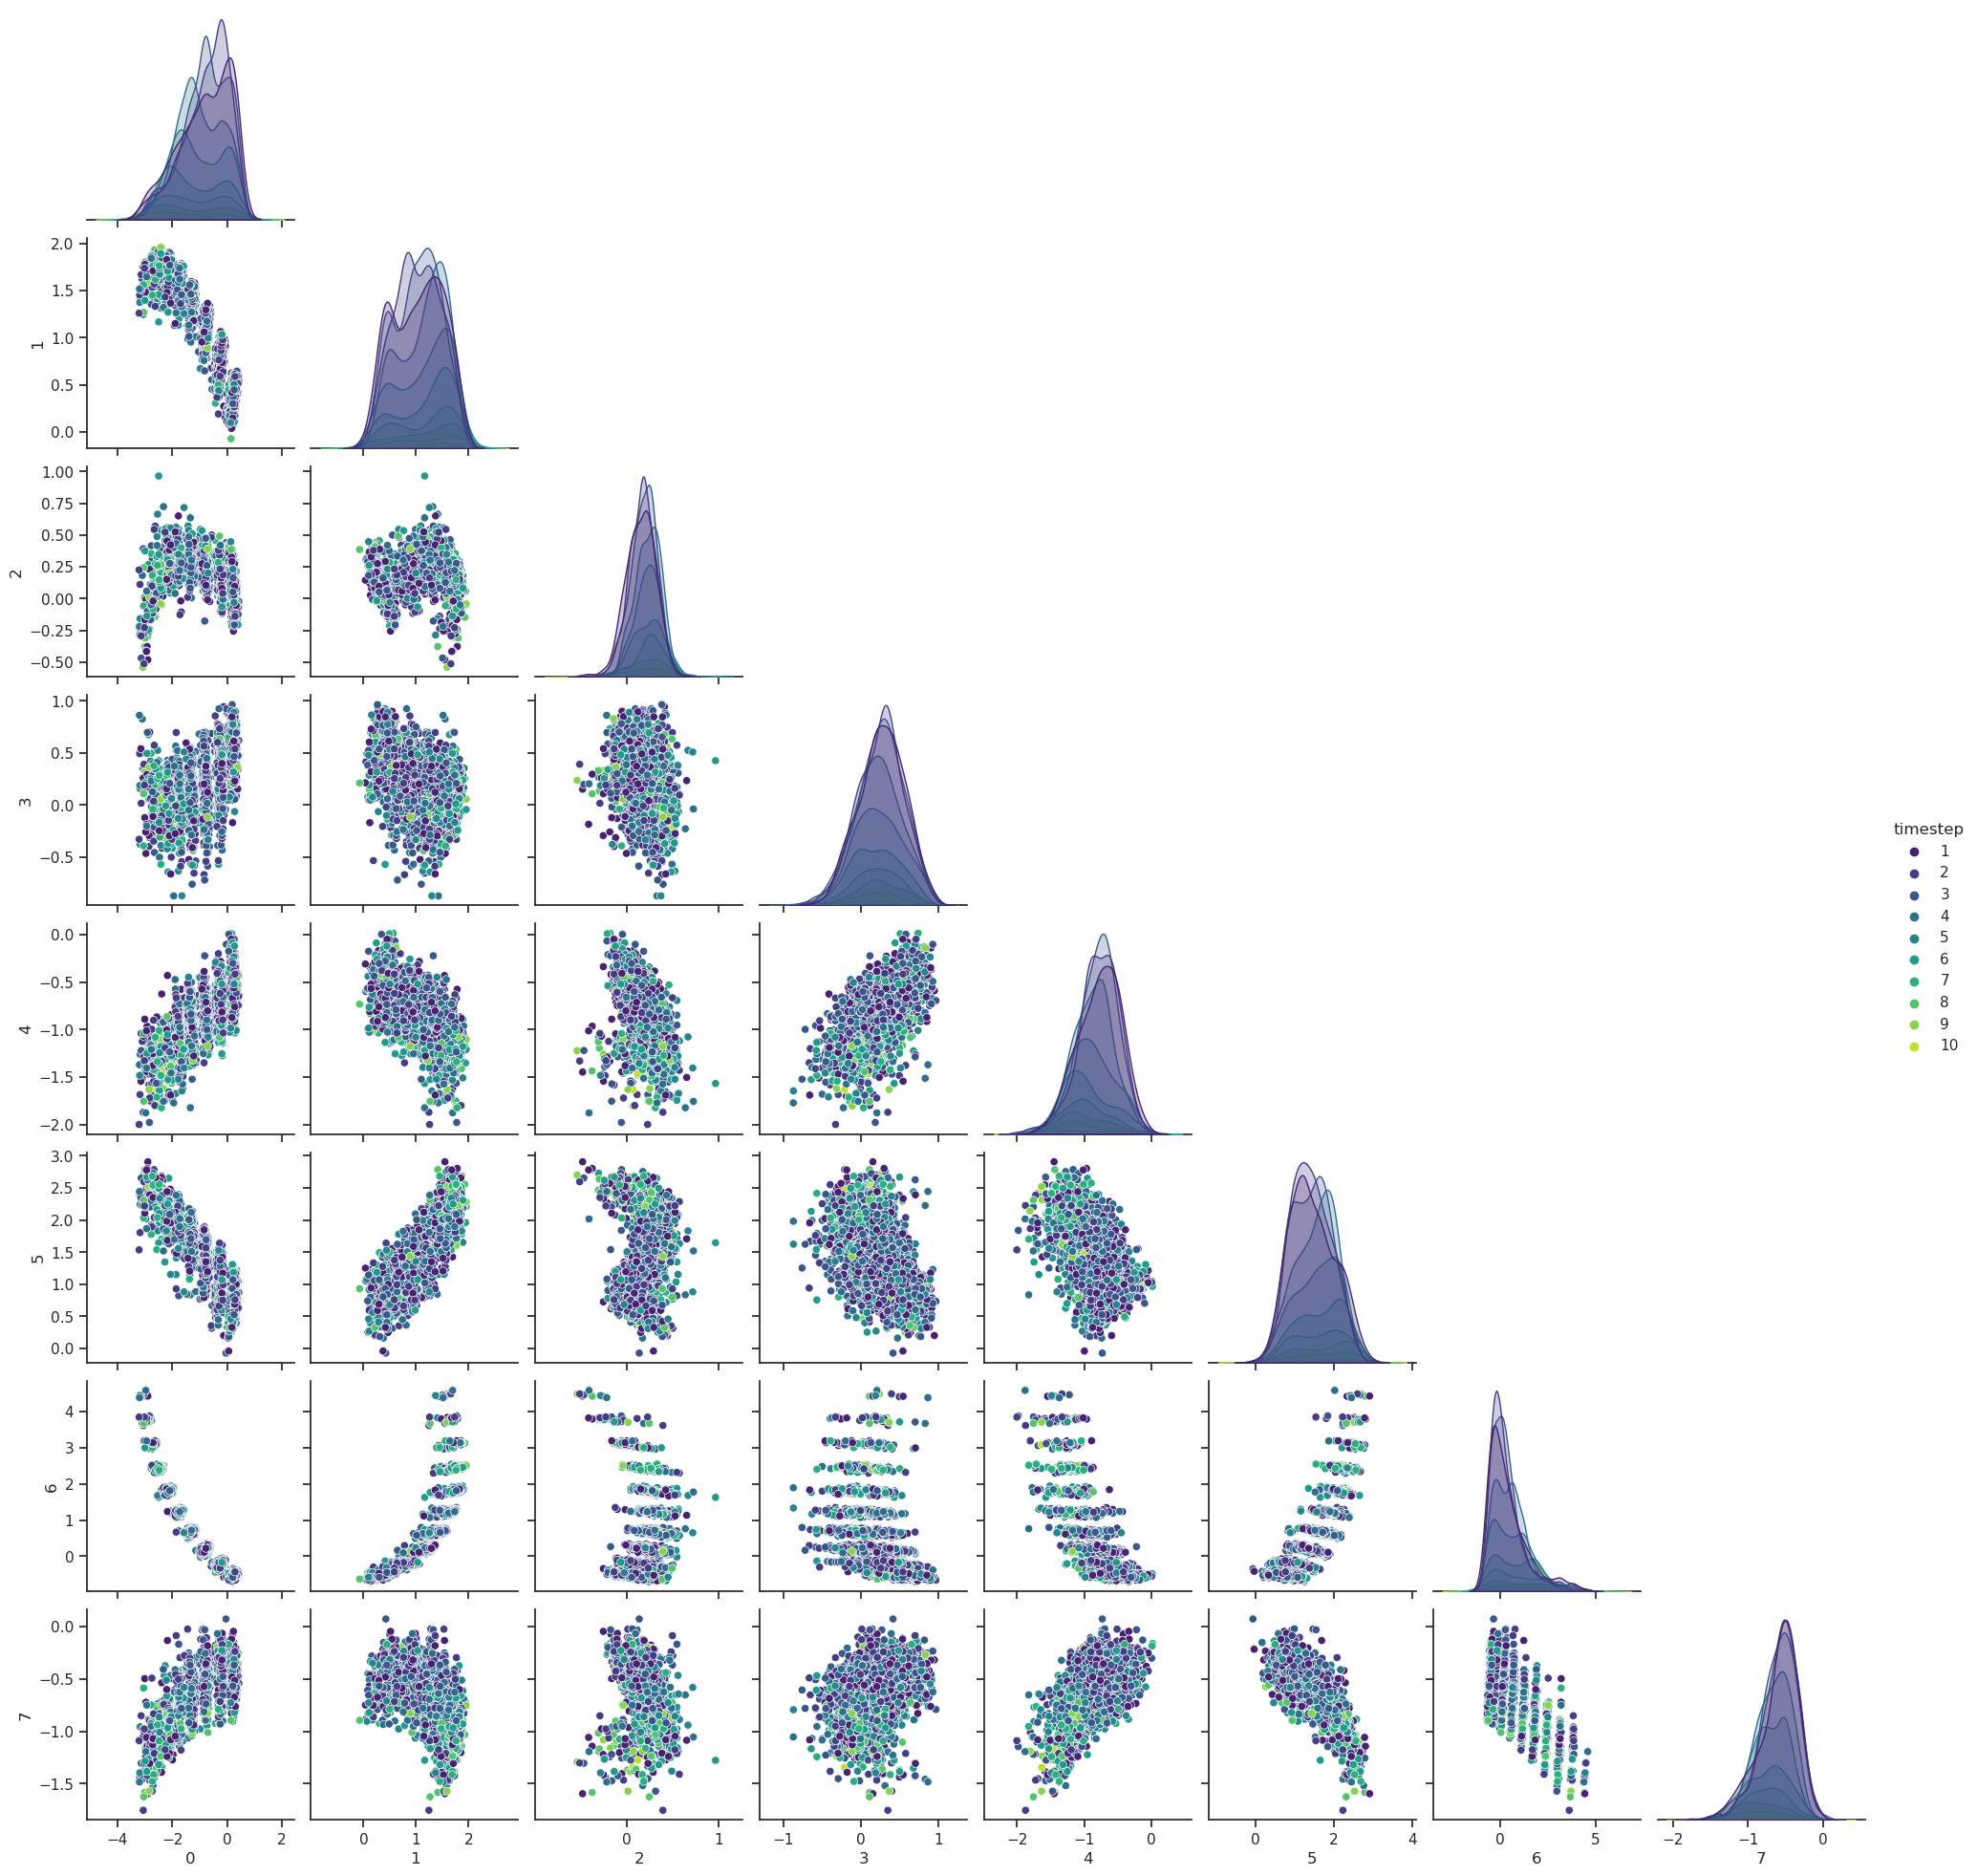

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(res_df,hue='timestep', corner=True, palette=sns.color_palette("viridis", res_df["timestep"].to_numpy().max()))